#### 1. Importing libraries

In [14]:
import re   # re library will be used for pattern matching 
import numpy as np
import pandas as pd
# - plotting
import seaborn as sns
from wordcloud import WordCloud # to plot wordcloud
import matplotlib.pyplot as plt
# - nltk
from nltk.stem import WordNetLemmatizer #reduces the words to its base form for NLP
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords 
# - sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer # to convert the text into numeric
from sklearn.metrics import confusion_matrix, classification_report


#### 2. Loading the dataset

In [15]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv("training.1600000.processed.noemoticon.csv",encoding=DATASET_ENCODING,names=DATASET_COLUMNS)
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [16]:
df.sample(5)

,target,ids,date,flag,user,text
1322673,4,2014822624,Wed Jun 03 02:48:15 PDT 2009,NO_QUERY,dannymekanik,@chrissieroyal in the studio until end of june...
86552,0,1754155571,Sun May 10 05:12:23 PDT 2009,NO_QUERY,kloe101,I should not be trusted with any form of techn...
184993,0,1967854457,Fri May 29 20:19:54 PDT 2009,NO_QUERY,abra_apricot,going to bed.. gotta work the next four days i...
1296457,4,2004119025,Tue Jun 02 07:41:48 PDT 2009,NO_QUERY,CourtneyOsgood,@HollyMaynard Welcomeeee!!!!
242752,0,1981385558,Sun May 31 09:02:31 PDT 2009,NO_QUERY,EllieStarfish,Headin to salty/ardrossan 4 a bbq..but its sti...


### 3. **Exploratory Data Analysis**

##### 3.1 Columns/features in data

In [17]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

##### 3.2. Length of data

In [18]:
print('length of data is', len(df))

length of data is 1600000


##### 3.3 Shape of data

In [19]:
df. shape

(1600000, 6)

##### 3.4 Data information

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


##### 3.5 Datatypes of all columns

In [21]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

##### 3.6: Checking for null values

In [22]:
np.sum(df.isnull().any(axis=1))

0

##### 3.7:Rows and columns in the dataset

In [23]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   6
Count of rows in the data is:   1600000


##### 3.8: Check unique target values

In [24]:
df['target'].unique()

array([0, 4], dtype=int64)

This output indicates that the 'target' column contains two unique values: 0 and 4. 
0 represent negative 
4 represent positive

##### 3.9: Check the number of target values

In [25]:
df['target'].nunique()

2

### 4.Data Visualization of "Target" Variables

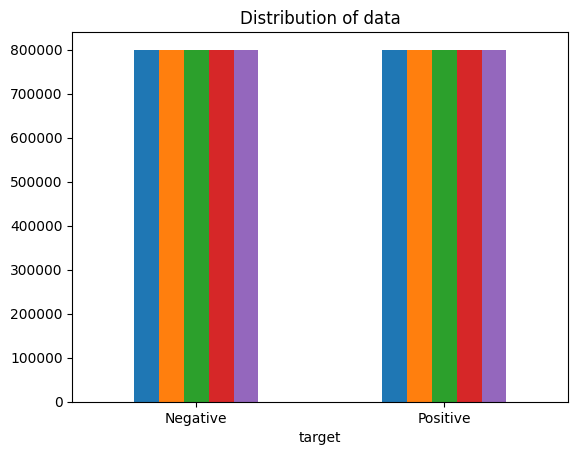

In [26]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['text']), list(df['target'])

<Axes: xlabel='target', ylabel='count'>

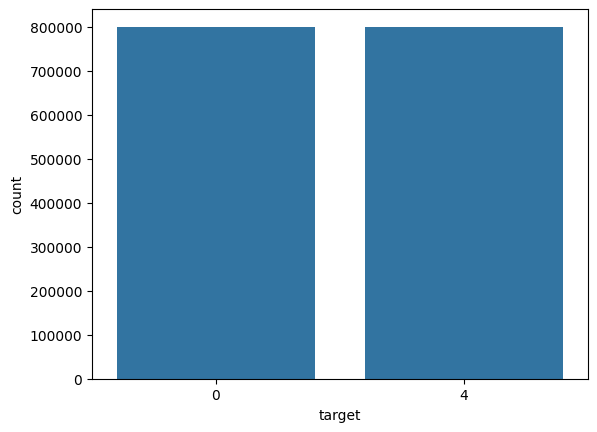

In [27]:
import seaborn as sns
sns.countplot(x='target', data=df)


## 5. **Data Preprocessing**

##### 5.1: Selecting the text and Target column for our further analysis

In [28]:
data=df[['text','target']].copy()

##### 5.2: Replacing the values to ease understanding. (Assigning 1 to Positive sentiment 4)

In [29]:
data['target'] = data['target'].replace(4,1)

In [30]:
data["target"]

0          0
1          0
2          0
3          0
4          0
          ..
1599995    1
1599996    1
1599997    1
1599998    1
1599999    1
Name: target, Length: 1600000, dtype: int64


We replaced 4 with 1 in sentiment labels to:


1) Align with the standard binary practice (0 for negative, 1 for positive).

2) Make it simpler to interpret—binary labels (0 and 1) are easier to understand than 0 and 4.

##### 5.4: Separating positive and negative tweets

In [31]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

##### 5.5: Taking one-fourth of the data so we can run it on our machine easily



In [32]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

##### 5.6: Combining positive and negative tweets

In [33]:
dataset = pd.concat([data_pos, data_neg])

##### 5.7: Making statement text in lowercase

In [34]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

The purposes of converting text to lowercase is:

- *Consistency*: Ensures uniformity by making all letters lowercase.
- *Simplification*: Makes the text data simpler for analysis.
- *Model Preparation*: Aids machine learning models by providing standardized input.
- *Improved Generalization*: Enhances the model's ability to capture sentiment patterns

##### 5.8: Defining set containing all stopwords in English.

In [35]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords  # Import stopwords module from nltk

Stopwordslist=list(stopwords.words('english'))# bringing in the english stopwords  
print(Stopwordslist)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BnGamer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### 5.9: Cleaning and removing the above stop words list from the tweet text

In [36]:
STOPWORDS = set(Stopwordslist)#set will ensure that we have unique stopwords only, we dont have to go with repeated stopwords
def cleaning_stopwords(text):# function takes text as input 
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])# looks for text that is not in stopwords after being split. A list is created using " "join
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))# function applied on the dataset's text column
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

Cleaning and removing the stopwords serve following purposes:

- Noise Reduction: Removing common words (stopwords) reduces irrelevant information.
- Improved Precision: Focuses on important content words for sentiment analysis accuracy.
- Computational Efficiency: Reduces data dimensionality for more efficient processing.
- Consistent Representation: Standardizes text for better model performance.

##### 5.10: Cleaning and removing punctuations

In [37]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    much time weekend work trip malmï¿½ frisat tod...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999     threw sign donnie bent get thingee made sad face
Name: text, dtype: object

Cleaning and removing punctuations is like tidying up the text for sentiment analysis:

- *Clarity*: Punctuations don't carry sentiment, so we remove them for clearer sentiment signals.
- *Consistency*: Ensures that "happy" and "happy!" are treated the same way.
- *Simplicity*: Simplifies the text, making it easier for the model to understand sentiment patterns.

##### 5.11: Cleaning and removing repeating characters

In [38]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)# re.sub is a function provided by re library which performs find and replace.
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))  # function applied
dataset['text'].tail()

19995    much time weekend work trip malmï¿½ frisat tod...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999     threw sign donnie bent get thingee made sad face
Name: text, dtype: object

Removing repeating characters is like cleaning up unnecessary noise:

- Noise Reduction: Words like "loooove" can be simplified to "love," reducing distractions.
- Consistency: Ensures uniform treatment of similar words for better model understanding.

##### 5.12: Cleaning and removing URLs

In [39]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995    much time weekend work trip malmï¿½ frisat tod...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999     threw sign donnie bent get thingee made sad face
Name: text, dtype: object

In [40]:
# Check if URLs are present in the original text
urls_present = dataset['text'].str.contains(r'(www.[^s]+)|(https?://[^s]+)')

# Check how many URLs were present
print(f"Number of URLs in the original dataset: {urls_present.sum()}")


C:\Users\BnGamer\AppData\Local\Temp\ipykernel_5600\3085336826.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  urls_present = dataset['text'].str.contains(r'(www.[^s]+)|(https?://[^s]+)')


Number of URLs in the original dataset: 0


##### 5.13: Cleaning and removing numeric numbers

In [41]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()



19995    much time weekend work trip malmï¿½ frisat tod...
19996                                     one day holidays
19997                     feeling right  hate damn humprey
19998    geezi hv read whole book personality types emb...
19999     threw sign donnie bent get thingee made sad face
Name: text, dtype: object

In [42]:
dataset['text'].head()

800000                    love healthuandpets u guys r best
800001    im meeting one besties tonight cant wait  girl...
800002    darealsunisakim thanks twitter add sunisa got ...
800003    sick really cheap hurts much eat real food plu...
800004                        lovesbrooklyn effect everyone
Name: text, dtype: object

##### 5.14: Getting tokenization of tweet text



In [43]:
import nltk
from nltk.tokenize import RegexpTokenizer

# Correct regular expression
tokenizer = RegexpTokenizer(r'\w+')

# Apply tokenization to the 'text' column
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)

# Print the head of the 'text' column
print(dataset['text'].head())


800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object


In [44]:
dataset['text'].head()


800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

## 6: **NLP Pre-Processing:**

##### 6.1: Applying Steming

*****PURPOSE OF STEMMING****:
The purpose of stemming is to reduce words to their base or root form.

In [45]:
import nltk
st = nltk.PorterStemmer() # using PorterStemmer algorithm
def stemming_on_text(data):
    text = [st.stem(word) for word in data]# steming every word in data
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))# funciton applied
dataset['text'].head()


800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [46]:
dataset['text'].tail()

19995    [much, time, weekend, work, trip, malmï, ½, fr...
19996                                 [one, day, holidays]
19997                [feeling, right, hate, damn, humprey]
19998    [geezi, hv, read, whole, book, personality, ty...
19999    [threw, sign, donnie, bent, get, thingee, made...
Name: text, dtype: object

In [47]:
dataset['text'].sample()

6711    [gah, cant, even, close, tags, days, man, skil...
Name: text, dtype: object

In [48]:
portstem=PorterStemmer()

In stemming the word is reduced to its base form using fixed set of rules.
suchas removeable -> remove. running -> run. 


##### 6.2: Applying lemmatizer

*****PURPOSE OF USING LEMMATIZER:*****
There are some occassion where stemming wont be enough like in ate -> eat (base word) stemming cant be done here.In such situations we use lemmatizers which uses the knowledge of language to derive the base word.

In [49]:
nltk.download('wordnet')#  download wordnet (lexical database of English).
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BnGamer\AppData\Roaming\nltk_data...


[nltk_data]   Package wordnet is already up-to-date!


800000             [love, healthuandpets, u, guys, r, best]
800001    [im, meeting, one, besties, tonight, cant, wai...
800002    [darealsunisakim, thanks, twitter, add, sunisa...
800003    [sick, really, cheap, hurts, much, eat, real, ...
800004                    [lovesbrooklyn, effect, everyone]
Name: text, dtype: object

In [50]:
dataset['text'].tail()

19995    [much, time, weekend, work, trip, malmï, ½, fr...
19996                                 [one, day, holidays]
19997                [feeling, right, hate, damn, humprey]
19998    [geezi, hv, read, whole, book, personality, ty...
19999    [threw, sign, donnie, bent, get, thingee, made...
Name: text, dtype: object

##### 6.3: Separating input feature and label

In [51]:
X=data.text
y=data.target

##### 6.4: Plot a cloud of words for negative tweets

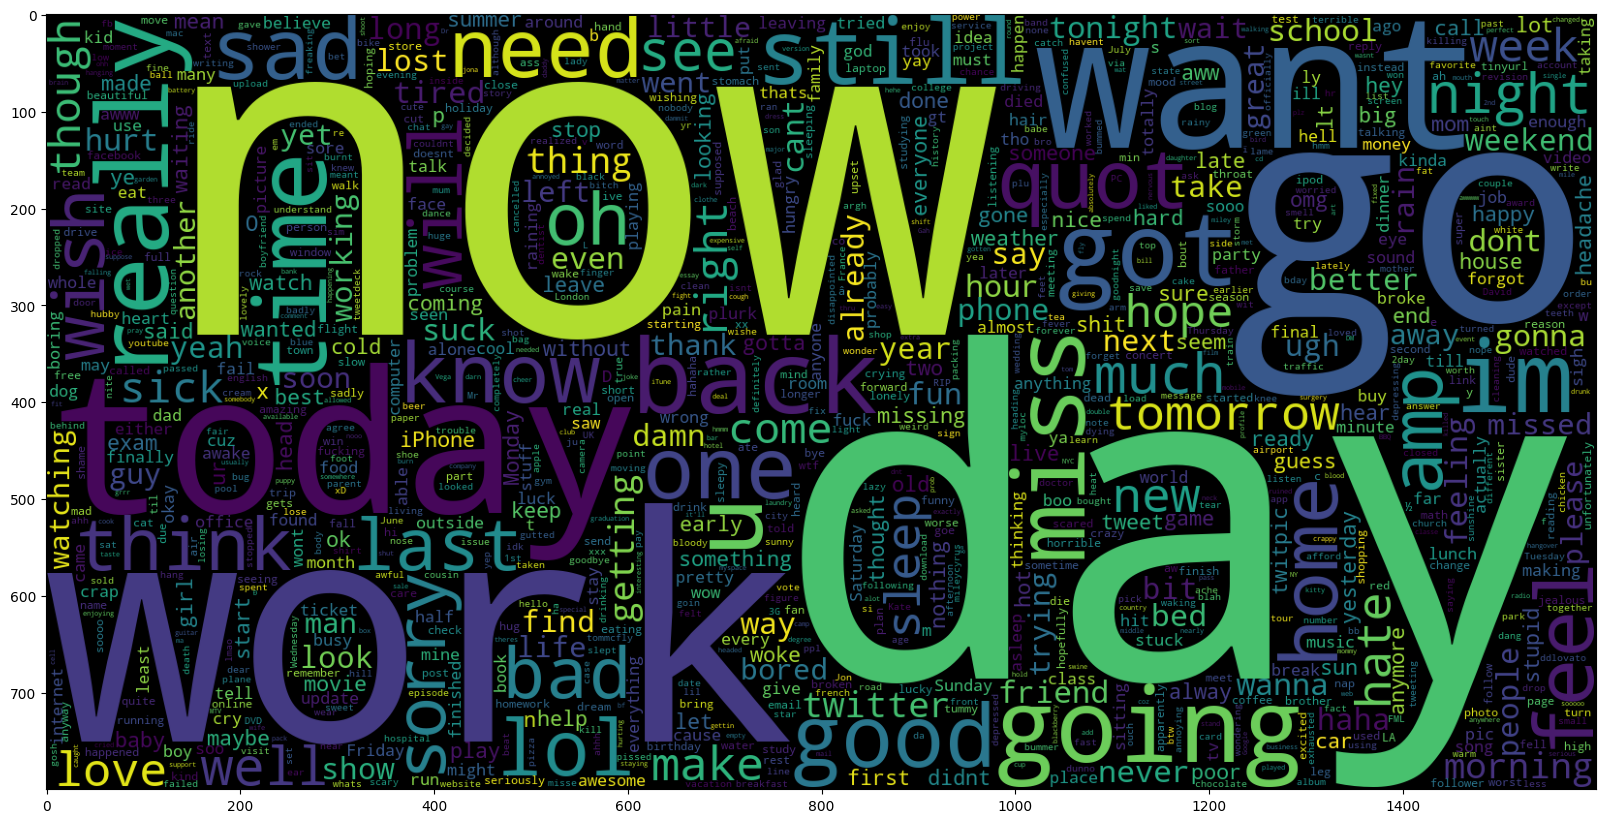

In [52]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

##### 6.5: Plot a cloud of words for positive tweets

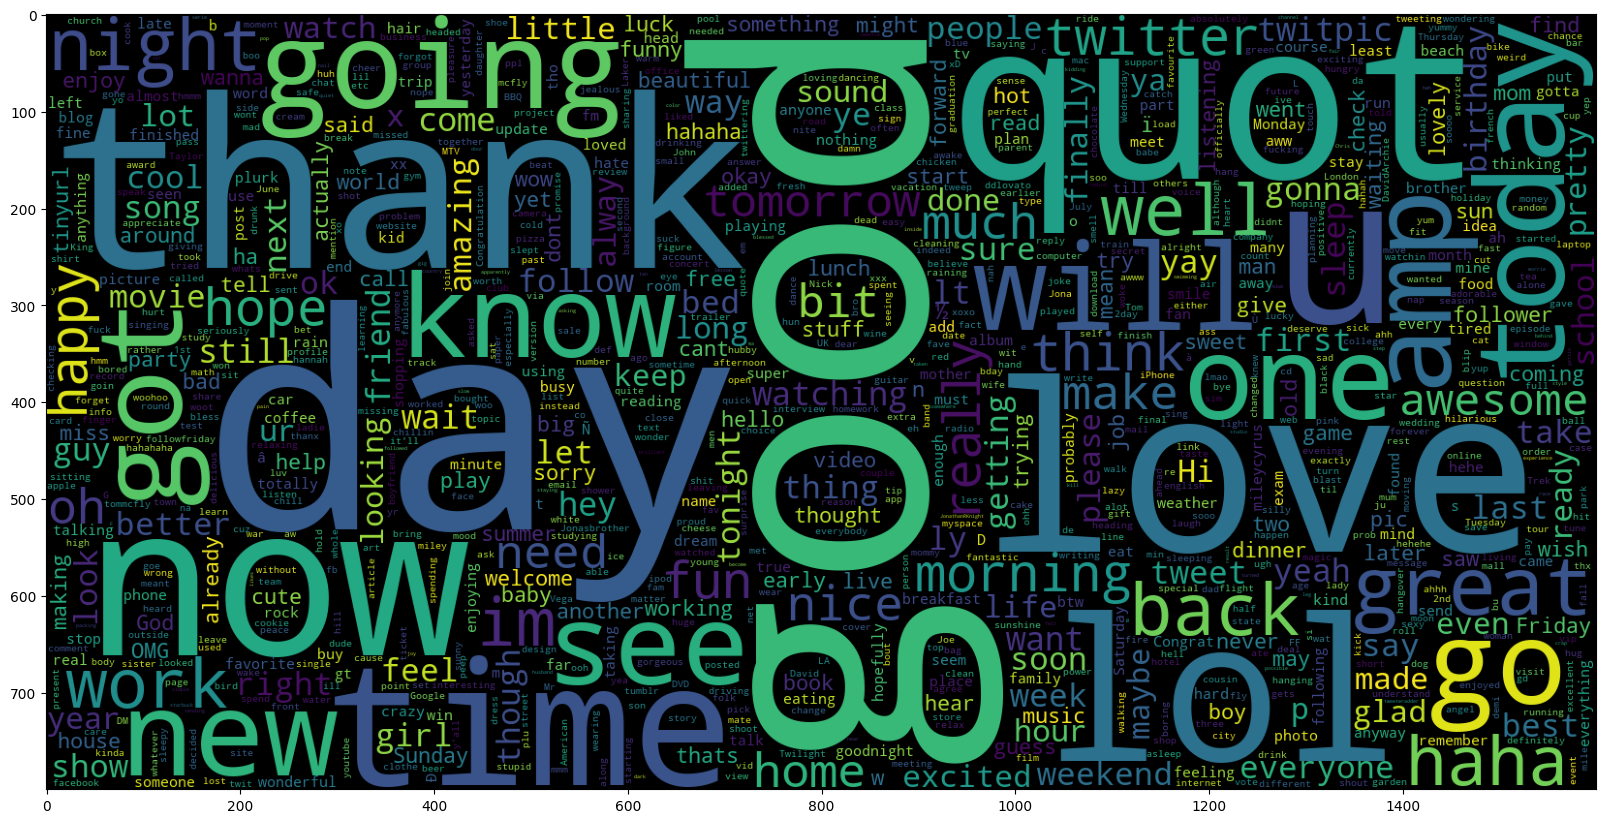

In [53]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

***PURPOSE OF WORDCLOUD:***
- Wordcloud can be used to check which words appear more frequently in a body of text. The larger the word in the cloud, the more often it appears in the positive/negative tweets.


### 7:  Splitting Our Data Into Train and Test Subsets

The train_test_split will do:

- Shuffling: Mix up your data randomly.
- Splitting: Divide it into training and testing sets (e.g., 95% for training, 5% for testing).
- Output: Get four sets: training features, testing features, training labels, and testing labels

In [54]:
from sklearn.model_selection import train_test_split
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

### 8. **Transforming the Dataset Using TF-IDF Vectorize**

##### 8.1:Fit the TF-IDF Vectorizer

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features=500000)
vectoriser.fit(X_train)
feature_names = vectoriser.get_feature_names_out()
print('No. of feature_words: ', len(feature_names))



No. of feature_words:  500000


##### 8.2: Transform the data using TF-IDF Vectorizer

In [56]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

### 9: **Function for Model Evaluation**

After training the model, we then apply the evaluation measures to check how the model is performing. Accordingly, we use the following evaluation parameters to check the performance of the models respectively:

- Accuracy Score
- Confusion Matrix with Plot
- ROC-AUC Curve



In [57]:
def model_Evaluate(model):
# Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### 10. **Model Building**

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     40100
           1       0.82      0.84      0.83     39900

    accuracy                           0.83     80000
   macro avg       0.83      0.83      0.83     80000
weighted avg       0.83      0.83      0.83     80000



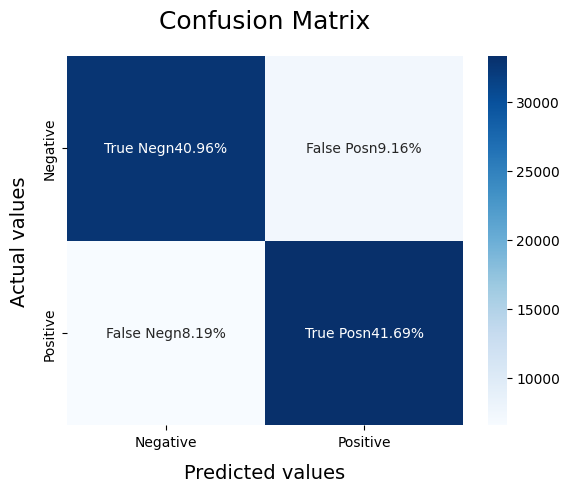

In [58]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

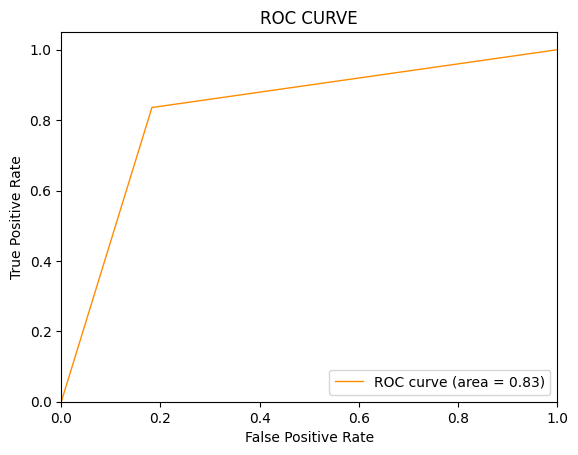

In [59]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### **11. Saving the LRmodel:**

In [60]:
import joblib

# Save the trained model to a file using joblib
joblib.dump(LRmodel, 'LRmodel.joblib')

# Load the trained model from the file
loaded_LRmodel = joblib.load('LRmodel.joblib')


## **11. Prediction**

In [61]:

def predict_sentiment(model, vectorizer, comments):
    # Transform the input tweets using the TF-IDF vectorizer
    transformed_comments = vectorizer.transform(comments)

    # Make predictions using the trained model
    predictions = model.predict(transformed_comments)

    return predictions




In [62]:
comments = pd.read_csv("comments.csv")
comments['Comment'] = comments['Comment'].astype(str)

# Predict sentiments using the created function
predicted_sentiments = predict_sentiment(LRmodel, vectoriser, comments['Comment'])

# Display the predictions
for comment, sentiment in zip(comments['Comment'], predicted_sentiments):
    print(f"Comment: {comment}\nPredicted Sentiment: {'Positive' if sentiment == 1 else 'Negative'}\n")
    # Saving the result in a csv file
    comments['Sentiment'] = predicted_sentiments
    comments.to_csv('comments_with_sentiment.csv', index=False)


Comment: What do YOU think to the current state of Foldable phones?
To check out that Tesla Electro Phone video: https://youtu.be/uPxkrGL0l7U
Predicted Sentiment: Positive

Comment: Well, finally someone who can compete with Samsung on this market. Competition is always good, hope Samsung will now realize they're not the only one and speed up the innovation in foldables
Predicted Sentiment: Positive

Comment: I wanna see them attempt something like the Z-Flip because it's something I can imagine myself actually using compared to the fold
And this already looks promising
Predicted Sentiment: Positive

Comment: 4:57 "And then actually coming with the charger to do that with" Respect +100 for Xiaomi for not getting in on the no charger included scam.
Predicted Sentiment: Negative

Comment: Personally, for me this was one of, if not the best video you've ever made. You were so simple but always on point. The green environment helped a lot as a background, and the lighting was exceptionally